In [1]:
!pip install spacy datasets
!python -m spacy download es_core_news_md

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.8.0/es_core_news_md-3.8.0-py3-none-any.whl (42.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
#En este punto se requiere reiniciar la sesión para que no dé error.
!pip install gensim

In [3]:
from collections import Counter, defaultdict
from datasets import load_dataset
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import spacy
from spacy.tokens import Doc

from sklearn.decomposition import PCA, TruncatedSVD
import random
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Práctica: Vectores a palabras

**Fecha de entrega: 16 de Marzo de 2025 @ 11:59pm**

Obtenga la matriz de co-ocurrencia para un corpus en español y realice los siguientes calculos:
- Las probabilidades conjuntas
$$p(w_i,w_j) = \frac{c_{i,j}}{\sum_i \sum_j c_{i,j}}$$
- Las probabilidades marginales
$$p(w_i) = \sum_j p(w_i,w_j)$$
- Positive Point Wise Mutual Information (PPMI):
$$PPMI(w_i,w_j) = \max\{0, \log_2 \frac{p(w_i,w_j)}{p(w_i)p(w_j)}\}$$

**Comparación de representaciones**

Aplica reducción de dimensionalidad (a 2D) de los vectores de la matríz con PPMI y de los vectores entrenados en español:

- Realiza un plot de 100 vectores aleatorios (que esten tanto en la matríz como en los vectores entrenados)
- Compara los resultados de los plots:
    - ¿Qué representación dirías que captura mejor relaciones semánticas?
    - Realiza un cuadro comparativo de ambos métodos con ventajas/desventajas

### 📁 [Carpeta con vectores](https://drive.google.com/drive/folders/1reor2FGsfOB6m3AvfCE16NOHltAFjuvz?usp=drive_link)

#Matrix de Co-ocurrencia.

In [4]:
ds_oscar = load_dataset("djstrong/oscar-small", "unshuffled_deduplicated_es")
ds_oscar=ds_oscar["train"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

oscar-small.py:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/129M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/648101 [00:00<?, ? examples/s]

In [5]:
nlp = spacy.load("es_core_news_md")

In [6]:
# Solo tokenización y lematización
def preprocesar(texto: str) -> list:
    doc = nlp(texto)
    tokens=[]
    for token in doc:
        if not token.is_stop and token.is_alpha and len(token.lemma_) > 2:
            tokens.append(token.lemma_.lower())
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop
        and token.is_alpha
        and len(token.lemma_) > 2
    ]
    return tokens


In [7]:
docs_procesados = [preprocesar(texto) for texto in ds_oscar[:5000]["text"]]  # 5K documentos para prueba

In [8]:
print(docs_procesados[0])

['librar', 'celulitis', 'gimnasio', 'piel', 'superfluo', 'mano', 'adelgazamiento', 'baile', 'fácil', 'adelgazamiento', 'vídeo', 'porción', 'comida', 'adelgazamiento', 'sitio', 'revocación', 'adelgazamiento', 'pan', 'blanco', 'adelgazar', 'grasa', 'hidrato', 'carbono', 'producto', 'alimentación', 'tabla', 'adelgazar', 'cacao']


In [9]:
# Contar frecuencias
frecuencias = defaultdict(int)
for doc in docs_procesados:
    for palabra in doc:
        frecuencias[palabra] += 1

In [10]:
# Vocabulario reducido (top 3000 palabras)
vocabulario = sorted(frecuencias, key=frecuencias.get, reverse=True)[:3000]
word2idx = {word: idx for idx, word in enumerate(vocabulario)}
vocab_size = len(vocabulario)

In [11]:
# Inicializar matriz
window_size = 5
co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

# Llenar matriz
for doc in docs_procesados:
    for i, palabra in enumerate(doc):
        if palabra not in word2idx:
            continue
        idx_palabra = word2idx[palabra]
        # Ventana de contexto
        start = max(0, i - window_size)
        end = min(len(doc), i + window_size + 1)
        for j in range(start, end):
            if j == i:
                continue
            contexto = doc[j]
            if contexto in word2idx:
                idx_contexto = word2idx[contexto]
                co_matrix[idx_palabra, idx_contexto] += 1


In [12]:
# Probabilidad conjunta
total = co_matrix.sum().astype(float)
p_conjunta = co_matrix / total

# Marginales
p_marginal_i = p_conjunta.sum(axis=1)
p_marginal_j = p_conjunta.sum(axis=0)

# PPMI
eps = 1e-8
pmi = np.log2((p_conjunta + eps) / (np.outer(p_marginal_i, p_marginal_j) + eps))
ppmi = np.maximum(pmi, 0)


In [13]:
if "artificial" in word2idx:
    idx = word2idx["artificial"]
    print(f"Palabra: 'artificial'")
    print(f"Co-ocurrencias totales: {co_matrix[idx].sum()}")
    print(f"PPMI máximo: {ppmi[idx].max():.2f}")

Palabra: 'artificial'
Co-ocurrencias totales: 160
PPMI máximo: 8.13


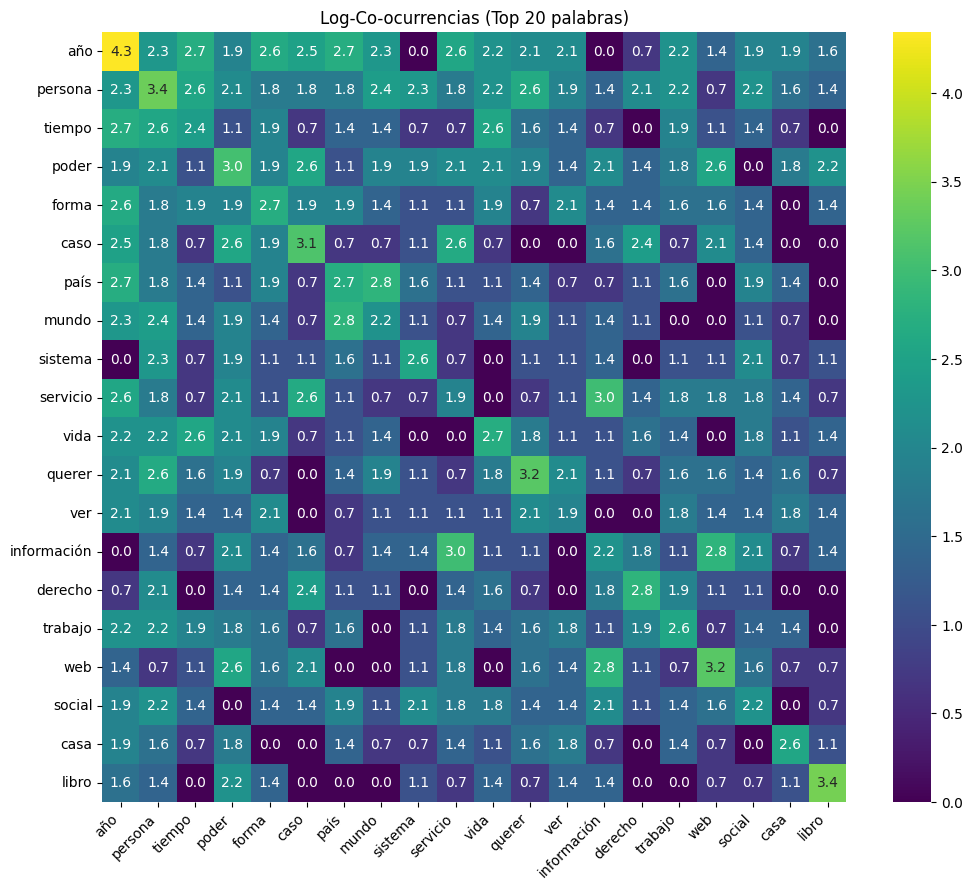

In [14]:
# Seleccionar top N palabras para visualización
top_n = 20
top_words = vocabulario[:top_n]
indices = [word2idx[word] for word in top_words]

# Submatriz reducida
submatrix = np.log1p(co_matrix[indices][:, indices])  # log(1 + x) para suavizar

# Configurar plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    submatrix,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    xticklabels=top_words,
    yticklabels=top_words,
)
plt.title("Log-Co-ocurrencias (Top 20 palabras)")
plt.xticks(rotation=45, ha="right")
plt.show()

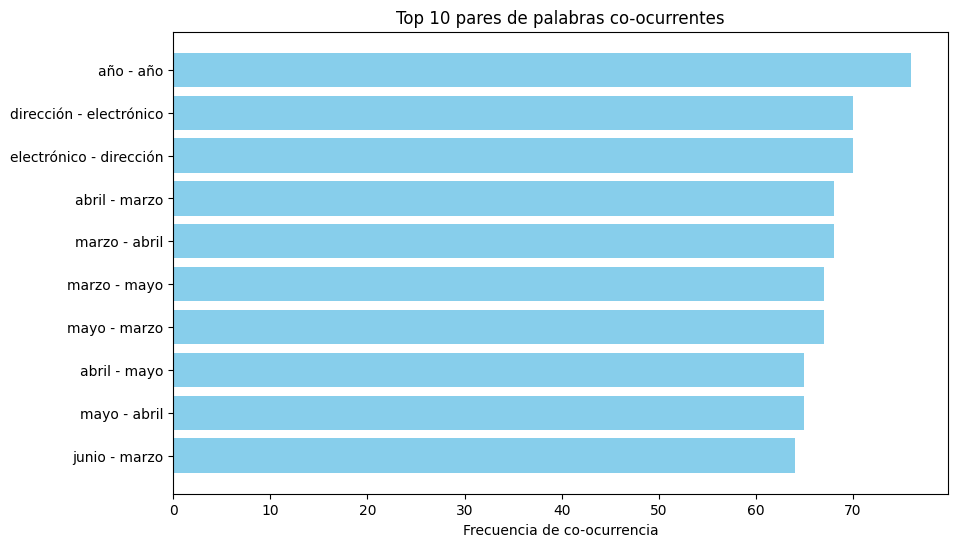

In [15]:
# Obtener pares y sus conteos
pares = []
for i in range(vocab_size):
    for j in range(vocab_size):
        if co_matrix[i, j] > 0:
            pares.append((vocabulario[i], vocabulario[j], co_matrix[i, j]))

# Ordenar y seleccionar top 10
top_pares = sorted(pares, key=lambda x: x[2], reverse=True)[:10]
palabras1, palabras2, conteos = zip(*top_pares)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(
    [f"{p1} - {p2}" for p1, p2 in zip(palabras1, palabras2)],
    conteos,
    color="skyblue",
)
plt.gca().invert_yaxis()
plt.xlabel("Frecuencia de co-ocurrencia")
plt.title("Top 10 pares de palabras co-ocurrentes")
plt.show()

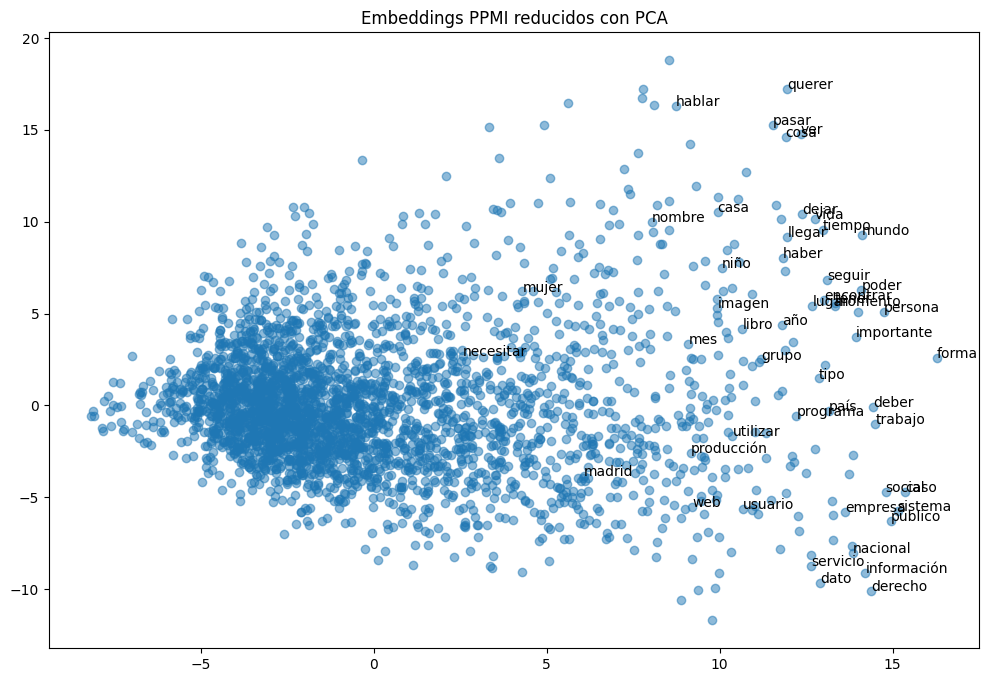

In [16]:
# Reducción a 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(ppmi)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
for i, word in enumerate(vocabulario[:50]):  # Primeras 50 palabras
    plt.annotate(word, (coords[i, 0], coords[i, 1]))
plt.title("Embeddings PPMI reducidos con PCA")
plt.show()

#Entrenamiento con word2vec

In [17]:
from gensim.models import word2vec
def load_model(model_path: str):
    try:
        print(model_path)
        return word2vec.Word2Vec.load(model_path)
    except:
        print(f"[WARN] Model not found in path {model_path}")
        return None

In [18]:
def report_stats(model) -> None:
    """Print report of a model"""
    print("Number of words in the corpus used for training the model: ", model.corpus_count)
    print("Number of words in the model: ", len(model.wv.index_to_key))
    print("Time [s], required for training the model: ", model.total_train_time)
    print("Count of trainings performed to generate this model: ", model.train_count)
    print("Length of the word2vec vectors: ", model.vector_size)
    print("Applied context length for generating the model: ", model.window)

In [19]:
from enum import Enum

class Algorithms(Enum):
    CBOW = 0
    SKIP_GRAM = 1

In [20]:
def train_model(sentences: list, model_name: str, vector_size: int, window=5, workers=2, algorithm = Algorithms.CBOW):
    model_name_params = f"{model_name}-vs{vector_size}-w{window}-{algorithm.name}.model"
    model_path = MODELS_DIR + model_name_params
    if load_model(model_path) is not None:
        print(f"Already exists the model {model_path}")
        return load_model(model_path)
    print(f"TRAINING: {model_path}")
    if algorithm in [Algorithms.CBOW, Algorithms.SKIP_GRAM]:
        print(f"Algorithm: {algorithm.name}")
        model = word2vec.Word2Vec(
            sentences,
            vector_size=vector_size,
            window=window,
            workers=workers,
            sg = algorithm.value,
            seed=42,
            )
    else:
        print("[ERROR] algorithm not implemented yet :p")
        return
    try:
        model.save(model_path)
    except:
        print(f"[ERROR] Saving model at {model_path}")
    return model

In [21]:
MODELS_DIR='/content/drive/MyDrive/Ciencia de Datos/8.Octavo Semestre/Temas selectos de PLN/Pŕacticas/Práctica 3/models/word2vec/'
#print(MODELS_DIR)
#model_name = "eswiki-md-300-CBOW.model"
#model = load_model(MODELS_DIR + model_name)

In [22]:
%%time
cbow_model = train_model(
    docs_procesados,
    "oscar",
    vector_size=300,
    window=5,
    workers=2,
    algorithm=Algorithms.CBOW
)

/content/drive/MyDrive/Ciencia de Datos/8.Octavo Semestre/Temas selectos de PLN/Pŕacticas/Práctica 3/models/word2vec/oscar-vs300-w5-CBOW.model
Already exists the model /content/drive/MyDrive/Ciencia de Datos/8.Octavo Semestre/Temas selectos de PLN/Pŕacticas/Práctica 3/models/word2vec/oscar-vs300-w5-CBOW.model
/content/drive/MyDrive/Ciencia de Datos/8.Octavo Semestre/Temas selectos de PLN/Pŕacticas/Práctica 3/models/word2vec/oscar-vs300-w5-CBOW.model
CPU times: user 76.6 ms, sys: 24.6 ms, total: 101 ms
Wall time: 1.31 s


In [23]:
report_stats(cbow_model)

Number of words in the corpus used for training the model:  5000
Number of words in the model:  4432
Time [s], required for training the model:  1.9723446600009993
Count of trainings performed to generate this model:  1
Length of the word2vec vectors:  300
Applied context length for generating the model:  5


In [24]:
cbow_model.wv["inteligencia"]

array([ 0.04165757, -0.04821971,  0.00483216, -0.14496522, -0.05065339,
       -0.00562813,  0.17452644,  0.02131141, -0.0532838 ,  0.24617663,
        0.17779644, -0.02619174, -0.01297676,  0.10910406,  0.07091733,
       -0.04470836,  0.12510493, -0.16614877, -0.12945238, -0.13718654,
        0.20485212,  0.13783675,  0.00863578,  0.34596136,  0.10583953,
        0.03990289, -0.3155279 , -0.09072086,  0.19238551,  0.16332641,
       -0.18138559, -0.09744203,  0.00307002,  0.00267275,  0.06566968,
        0.06526612,  0.05128861, -0.23658021, -0.07961185,  0.02134838,
        0.09567888,  0.07105119,  0.01825845,  0.15918534,  0.12456226,
        0.00385332,  0.18751284,  0.14758871,  0.03190228,  0.15603536,
       -0.15641929, -0.15726814, -0.00981043, -0.0357087 ,  0.13249502,
        0.00067485, -0.03141237,  0.07284488,  0.12540913, -0.04998856,
       -0.08709517,  0.05860715, -0.19410045,  0.10188187, -0.10821956,
        0.13452381,  0.00194355,  0.10161041, -0.20990396,  0.22

#Comparación entre Word2Vec y PPMI

In [25]:
# Palabras del modelo Word2Vec
words_word2vec = set(cbow_model.wv.key_to_index.keys())

# Palabras de la matriz PPMI
words_ppmi = set(vocabulario)

# Intersección de vocabularios
common_words = list(words_word2vec & words_ppmi)
print(f"Palabras comunes: {len(common_words)}")

# Seleccionar 100 palabras aleatorias
random.seed(42)
selected_words = random.sample(common_words, 100)


Palabras comunes: 3000


In [26]:
# Vectores Word2Vec
word2vec_vectors = np.array([cbow_model.wv[word] for word in selected_words])

# Vectores PPMI (usar los índices de la matriz)
ppmi_indices = [word2idx[word] for word in selected_words]
ppmi_vectors = ppmi[ppmi_indices]

In [27]:
# Se usa PCA para reducir dimensionalidad
pca = PCA(n_components=2)
word2vec_2d = pca.fit_transform(word2vec_vectors)

ppmi_2d = pca.fit_transform(ppmi_vectors)

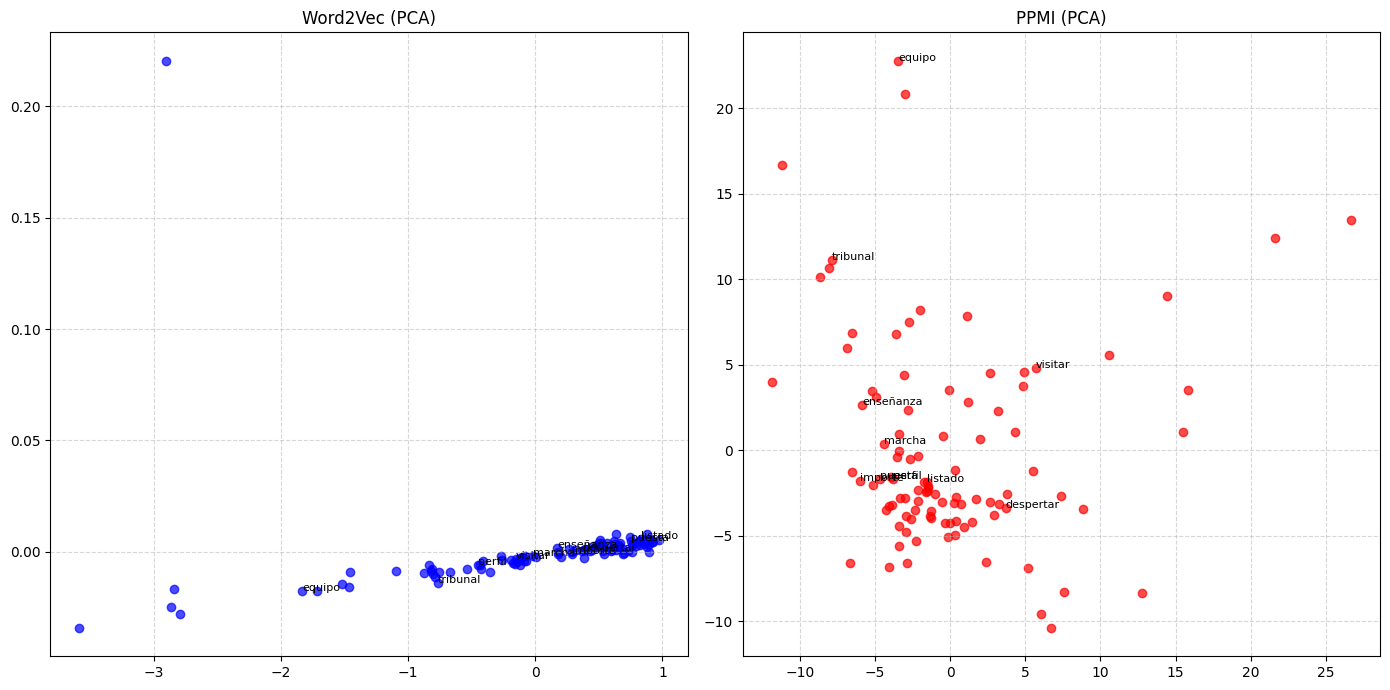

In [28]:
plt.figure(figsize=(14, 7))

# Subplot para Word2Vec
plt.subplot(1, 2, 1)
plt.scatter(word2vec_2d[:, 0], word2vec_2d[:, 1], alpha=0.7, c='blue')
plt.title('Word2Vec (PCA)')
plt.grid(True, linestyle='--', alpha=0.5)

# Anotar algunas palabras clave
for i, word in enumerate(selected_words[:10]):  # Primeras 10 para claridad
    plt.annotate(word, (word2vec_2d[i, 0], word2vec_2d[i, 1]), fontsize=8)

# Subplot para PPMI
plt.subplot(1, 2, 2)
plt.scatter(ppmi_2d[:, 0], ppmi_2d[:, 1], alpha=0.7, c='red')
plt.title('PPMI (PCA)')
plt.grid(True, linestyle='--', alpha=0.5)

# Anotar mismas palabras para comparar
for i, word in enumerate(selected_words[:10]):
    plt.annotate(word, (ppmi_2d[i, 0], ppmi_2d[i, 1]), fontsize=8)

plt.tight_layout()
plt.show()

Lo que podemos observar es que en el caso de Word2Vec el rango de valores es mucho menor que en el caso de PPMI, pues como podemos observar, los valores en x van desde -4 hasta 1 para x y de -0.01 a 0.2 para y, por otro lado, para PPMI los valores van desde -10 hasta 25 en x y desde -10 hasta 25 para y, lo que nos habla de una mayor distancia entre los vectores. Al tratarse de las mismas palabras las relaciones semánticas deberían de ser similares y si ciertas palabras están relacionadas PPMI también debería de captar esto, sin embargo, podemos notar que hay una mayor dispersión para el caso de PPMI, lo que nos habla de que es peor a la hora de captar relaciones semánticas. De este modo, la representación vectorial mediante Word2Vec es mejor para captar relaciones semánticas.


| Característica          | Word2Vec              | PPMI                  |
|-------------------------|-----------------------|-----------------------|
| Relaciones semánticas    | Captura mejor         | Captura parcial       |
| Densidad informativa     | Alta (vectores densos)| Baja (matriz dispersa)|
| Interpretabilidad visual | Buena                 | Limitada              |
| Contextos locales        | Modela bien           | Modela explícitamente |
| Palabras raras           | Manejo regular        | Pobre manejo          |



